<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [177]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%cd ../../../docs/DLSchool/W3

C:\Users\mkapchenko\Dropbox\perso\GitHub\Neuron\docs\DLSchool\W3


## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [266]:
data = pd.read_csv('train.csv')

In [267]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [268]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


видим коллинеарный столбик: TotalSpent = CLientPeriod * MonthlySpending. Дропаем его.

In [271]:
def data_transform(data):
    data.drop(columns=['TotalSpent'], inplace=True)
    data.replace('No internet service', 'No', inplace=True)
    data['HasMultiplePhoneNumbers'].replace('No phone service', 'No', inplace=True)
    data['HasContractPhone'].replace('Two year', 'One year', inplace=True)
    

In [272]:
data_transform(data)
num_cols.remove('TotalSpent')

In [273]:
data.isna().aggregate(sum)

ClientPeriod                0
MonthlySpending             0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 19 columns):
ClientPeriod                5282 non-null int64
MonthlySpending             5282 non-null float64
Sex                         5282 non-null object
IsSeniorCitizen             5282 non-null int64
HasPartner                  5282 non-null object
HasChild                    5282 non-null object
HasPhoneService             5282 non-null object
HasMultiplePhoneNumbers     5282 non-null object
HasInternetService          5282 non-null object
HasOnlineSecurityService    5282 non-null object
HasOnlineBackup             5282 non-null object
HasDeviceProtection         5282 non-null object
HasTechSupportAccess        5282 non-null object
HasOnlineTV                 5282 non-null object
HasMovieSubscription        5282 non-null object
HasContractPhone            5282 non-null object
IsBillingPaperless          5282 non-null object
PaymentMethod               5282 non-null object
Churn       

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

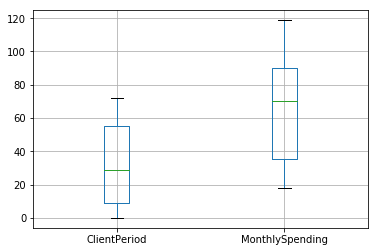

In [275]:
data[num_cols].boxplot()

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [276]:
len(cat_cols)

16

Wall time: 1.36 s


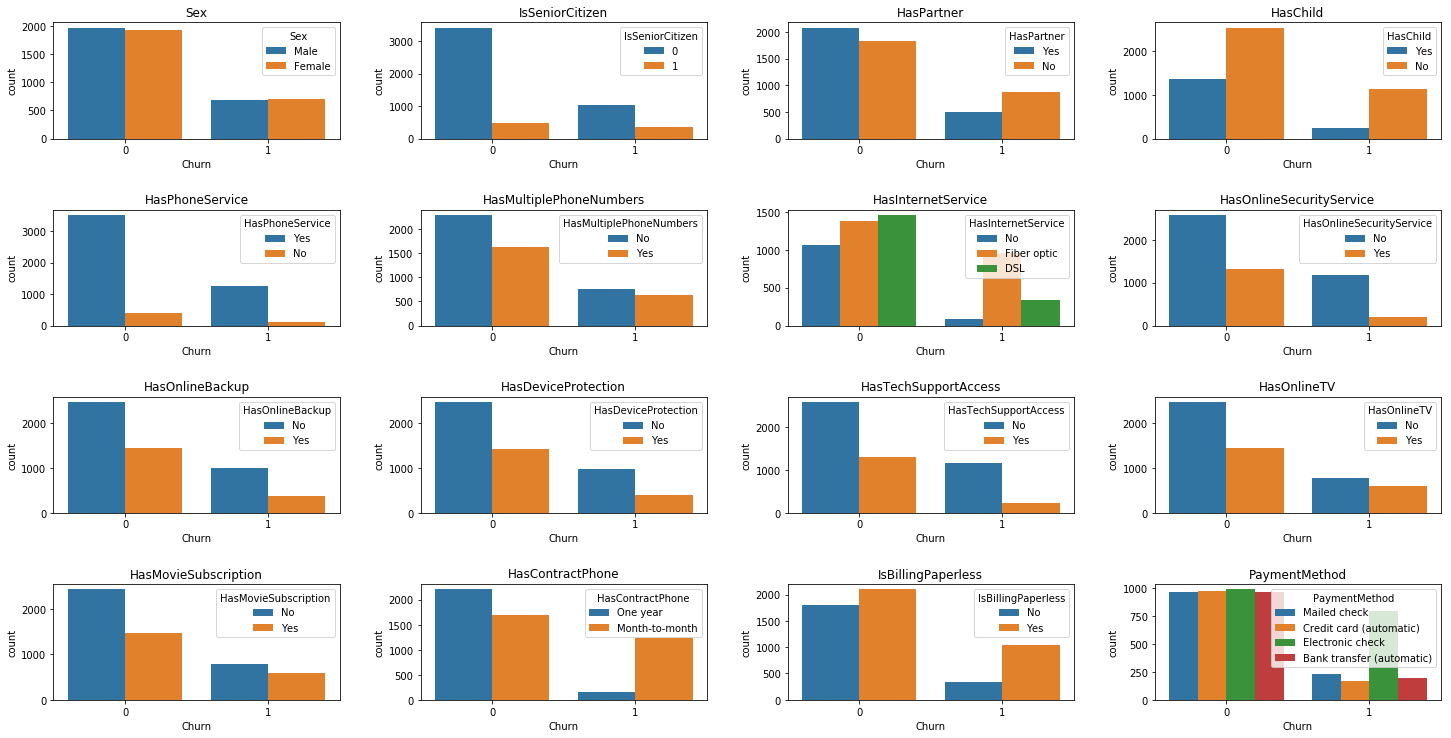

In [277]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
axes = axes.reshape(1,-1)[0]
fig.tight_layout(h_pad=5, w_pad=5)
for ix, col in enumerate(cat_cols):
    axes[ix].set_title(col)
#     data[col].value_counts().plot(kind='barh', ax=axes[ix])
    sns.countplot(x='Churn', hue=col, data=data, ax=axes[ix])

<font color='blue'>
Мы видим что в большинстве явной несбалансировки нету: те кто ушли и те кто остались имеют примерно одинаковое распределение внутригрупп.

Другими словами мы не видим явной категории которая сильно влияла на ответ Churn

Однако, мы можем заметить, что в среднем, клиенты у кого "No internet service" очень редко остаются, и больше чем в 90% случаях уходят.

Также по гистограмме HasCоntractPhone видим что в случае One year & Two year клиент почти навеняка уйдёт.

Наконец категоии Sex, IsSeniorCitizen, HasChild, HasPhoneService, HasMultiplePhoneNumbers в равной пропорции разбивают выборку там где Churn = 0 или 1, то есть они не очень информативны для нас.
</font> 

## Конец анализа даных.
## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [278]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [279]:
scaler = StandardScaler()
scaler.fit(data[num_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [280]:
scaled_features = scaler.transform(data[num_cols])
data[num_cols] = scaled_features

In [281]:
data.head()

,ClientPeriod,MonthlySpending,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,0.920767,-1.505447,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No,No,One year,No,Mailed check,0
1,1.613288,-1.294998,Male,0,Yes,No,Yes,Yes,No,No,No,No,No,No,No,One year,No,Credit card (automatic),0
2,-1.279005,0.363737,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,-0.016173,0.476418,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,1.124450,1.667856,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),0


In [282]:
df = pd.concat([data[num_cols], pd.get_dummies(data[cat_cols])], axis=1)
data_features = data.iloc[:, :-1]
answer = data['Churn']
df.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,...,HasMovieSubscription_No,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.920767,-1.505447,0,0,1,0,1,0,1,0,...,1,0,0,1,1,0,0,0,0,1
1,1.613288,-1.294998,0,0,1,0,1,1,0,0,...,1,0,0,1,1,0,0,1,0,0
2,-1.279005,0.363737,0,0,1,1,0,1,0,0,...,1,0,1,0,0,1,0,0,1,0
3,-0.016173,0.476418,1,1,0,0,1,1,0,0,...,1,0,1,0,1,0,0,0,0,1
4,1.124450,1.667856,0,1,0,0,1,0,1,0,...,0,1,0,1,1,0,0,1,0,0


In [283]:
X, Xtest, y, ytest = train_test_split(df, answer, test_size=0.2)

In [284]:
X.shape, y.shape

((4225, 36), (4225,))

## Logistic Regression

In [286]:
params = {'C' : [100, 10, 1, 0.1, 0.01, 0.001] }

logreg_estim = LogisticRegression()
gridLR = GridSearchCV(estimator=logreg_estim, param_grid=params, scoring='roc_auc', cv=5, refit=True)

gridLR.fit(X, y);

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [287]:
logreg = gridLR.best_estimator_
print(f'Best   ROC-AUC score is {gridLR.best_score_}')
print(f'Manual ROC-AUC score is {roc_auc_score(y, logreg.predict_proba(X)[:,1])}')
logreg

Best   ROC-AUC score is 0.8416209776473511
Manual ROC-AUC score is 0.8453258750007935


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### LogisticRegressionCV

In [288]:
logregCV = LogisticRegressionCV()
logregCV.fit(X,y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [289]:
roc_auc_score(y, logregCV.predict_proba(X)[:,1])

0.8453991656408862

## Random Forest

In [291]:
from sklearn.ensemble import RandomForestClassifier
columns=['param_criterion', 'param_max_depth', 'param_n_estimators',  'std_test_score', 'mean_test_score']

In [293]:
%%time

RF = RandomForestClassifier()

paramsRF = {'n_estimators': range(100,200,25) , 'criterion' : ['gini', 'entropy'], 'max_depth': range(5,7)}

gridRF = GridSearchCV(estimator=RF, param_grid=paramsRF, scoring='roc_auc', n_jobs=-1)

gridRF.fit(X,y)

rf = gridRF.best_estimator_

Wall time: 57.5 s


In [294]:
gridRF.best_score_

0.8409562613702579

<font color='blue'> Посмотрим на таблицу победителей gridSearchCV 

In [295]:
pd.DataFrame(gridRF.cv_results_, columns=columns).sort_values(by='mean_test_score', ascending=False).head(10)

,param_criterion,param_max_depth,param_n_estimators,std_test_score,mean_test_score
42,entropy,6,190,0.024563,0.840956
40,entropy,6,170,0.024301,0.840926
37,entropy,6,140,0.023755,0.840888
18,gini,6,170,0.024356,0.840739
39,entropy,6,160,0.023926,0.840568
19,gini,6,180,0.024281,0.840537
35,entropy,6,120,0.024776,0.840500
20,gini,6,190,0.024924,0.840474
16,gini,6,150,0.023778,0.840456
38,entropy,6,150,0.024545,0.840392


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

## XGBoost

In [296]:
import xgboost as xgb

dm = xgb.DMatrix(data=X, label=y)

xgbclf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1)

In [298]:
xgbparams = {'n_estimators': [100,200], 'max_depth': [2,3,4,5,6], 'learning_rate ': [0.1, 1.], }

xgbgrid = GridSearchCV(estimator=xgbclf, param_grid=xgbparams, cv=5, scoring='roc_auc')

In [299]:
xgbgrid.fit(X, y);

[12:33:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rate  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:33:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:33:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rate  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

## Catboost

In [315]:
from catboost import CatBoostClassifier

data_features = data.iloc[:, :-1]
answer = data['Churn']

# data_features[num_cols] = scaler.transform(data_features[num_cols])

Xc, Xctest, yc, yctest = train_test_split(data_features, answer, test_size=0.2, random_state=42)

columns=['param_iterations', 'param_depth', 'param_learning_rate',  'std_test_score', 'mean_test_score']

cat = CatBoostClassifier(cat_features=cat_cols, random_state=42)

In [316]:
catparams =  {'iterations': [50, 100, 200], 'depth': [2,3,4,5], 'learning_rate': [0.05, 0.1, 0.2], }
catgrid = GridSearchCV(estimator=cat, param_grid=catparams, cv=5, scoring='roc_auc')

In [317]:
%%time
catgrid.fit(Xc,yc)

0:	learn: 0.6750589	total: 12.7ms	remaining: 621ms
1:	learn: 0.6580053	total: 22.5ms	remaining: 539ms
2:	learn: 0.6424415	total: 41.3ms	remaining: 646ms
3:	learn: 0.6292262	total: 56.1ms	remaining: 646ms
4:	learn: 0.6166038	total: 70.9ms	remaining: 638ms
5:	learn: 0.6046033	total: 86.3ms	remaining: 633ms
6:	learn: 0.5935288	total: 94.9ms	remaining: 583ms
7:	learn: 0.5837506	total: 107ms	remaining: 563ms
8:	learn: 0.5744798	total: 120ms	remaining: 549ms
9:	learn: 0.5661060	total: 134ms	remaining: 537ms
10:	learn: 0.5584468	total: 148ms	remaining: 526ms
11:	learn: 0.5510437	total: 164ms	remaining: 519ms
12:	learn: 0.5443399	total: 179ms	remaining: 508ms
13:	learn: 0.5382530	total: 194ms	remaining: 498ms
14:	learn: 0.5313501	total: 212ms	remaining: 494ms
15:	learn: 0.5256033	total: 227ms	remaining: 483ms
16:	learn: 0.5194768	total: 243ms	remaining: 471ms
17:	learn: 0.5139420	total: 258ms	remaining: 459ms
18:	learn: 0.5093343	total: 275ms	remaining: 449ms
19:	learn: 0.5049250	total: 288ms	

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F1803CEC18>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [2, 3, 4, 5], 'iterations': [50, 100, 200],
                         'learning_rate': [0.05, 0.1, 0.2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [331]:
cat = catgrid.best_estimator_

In [318]:
pd.DataFrame(catgrid.cv_results_, columns=columns).sort_values(by='mean_test_score', ascending=False).head(10)

,param_iterations,param_depth,param_learning_rate,std_test_score,mean_test_score
22,100,4,0.1,0.011907,0.850130
11,50,3,0.2,0.011586,0.849661
13,100,3,0.1,0.012061,0.849644
15,200,3,0.05,0.011864,0.849460
14,100,3,0.2,0.011035,0.849406
20,50,4,0.2,0.011568,0.849201
5,100,2,0.2,0.011216,0.849153
24,200,4,0.05,0.011991,0.849030
31,100,5,0.1,0.011314,0.849016
28,50,5,0.1,0.011597,0.848894


## Resume

In [332]:
metric = roc_auc_score
res = {}
for estimator in [logreg, logregCV, rf, bestxgbclf, cat]:
    name= estimator.__class__.__name__
    if name == 'CatBoostClassifier':
        score_train = metric(yc, estimator.predict_proba(Xc)[:,1])
        score_test = metric(yctest, estimator.predict_proba(Xctest)[:,1])
    else:    
        score_train = metric(y, estimator.predict_proba(X)[:,1])
        score_test = metric(ytest, estimator.predict_proba(Xtest)[:,1])
    res[name] = [round(score_train, 4), round(score_test, 4)]  
    
res = pd.DataFrame.from_dict(data=res, orient='index', columns=['train', 'test'])
res.sort_values(by='test', ascending=False)

,train,test
RandomForestClassifier,0.8711,0.8480
LogisticRegressionCV,0.8454,0.8462
LogisticRegression,0.8453,0.8461
CatBoostClassifier,0.8621,0.8274
XGBClassifier,0.7029,0.7130


# Предсказания OHE

In [321]:
best_model = rf

In [326]:
X_test = pd.read_csv('./test.csv')
data_transform(X_test)
submission = pd.read_csv('./submission.csv', index_col='Id')

In [327]:
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test = pd.concat([X_test[num_cols], pd.get_dummies(X_test[cat_cols])], axis=1)

In [328]:
submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv')

In [111]:
submission.T

Id,0,1,2,3,4,5,6,7,8,9,...,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760
Churn,0.048028,0.633983,0.662318,0.022064,0.009519,0.109282,0.510966,0.221946,0.07294,0.341222,...,0.479454,0.18019,0.656297,0.062321,0.064417,0.142435,0.025505,0.807139,0.512185,0.023387


# Предсказания CAT

In [320]:
kaggle_cat = cat
X_test = pd.read_csv('./test.csv')
data_transform(X_test)
submission = pd.read_csv('./submission.csv', index_col='Id')

submission['Churn'] = kaggle_cat.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv')

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.